In [55]:
import os
import h5py
from time import time
from tqdm import tqdm

import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

from sklearn.decomposition import PCA
from scipy.linalg import svd as SVD
import pywt
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning, SparseCoder

from sklearn.metrics import mean_squared_error, r2_score
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from skimage.metrics import mean_squared_error as image_mse

import imageio
import scipy.io as sio
from PIL import Image
from skimage.color import rgb2gray

my_box = dict(boxstyle='round', facecolor='lightgrey', edgecolor='k', alpha=0.5)

In [56]:
df_perm = np.load('data/data_500_128x128.npy')
df_perm_f = np.reshape(df_perm, (df_perm.shape[0], -1))
print('Permeability: {} [{}]'.format(df_perm.shape, df_perm_f.shape))

Permeability: (500, 128, 128) [(500, 16384)]


In [ ]:
fig = plt.figure(figsize=(12,6.5))
gs = GridSpec(3, 6, figure=fig, width_ratios=[1,1,1,1,1,0.1])
k = 0
for i in range(3):
    for j in range(5):
        ax = fig.add_subplot(gs[i, j])
        im = ax.imshow(df_perm[k], cmap='jet')
        ax.set(xticks=[], yticks=[], title='R{}'.format(k+1))
        k += 1

cb = fig.add_subplot(gs[:, 5])
plt.colorbar(im, cax=cb, label='Log-Permeability [mD]')

plt.tight_layout()
plt.show()

***
# SVD

In [ ]:
u, s, vt = SVD(df_perm_f.T, full_matrices=True)
ss = np.diag(s)
print('U: {} | S: {} | Vt: {}'.format(u.shape, ss.shape, vt.shape))

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(12,5), sharex=True, sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        ax = axs[i,j]
        ax.imshow(u[:,k].reshape(128,128), cmap='jet')
        ax.set(xticks=[], yticks=[], title='$sv_{%d}$'%(k+1))
        k += 1
plt.tight_layout()
plt.show()

In [10]:
cutoffs = [0.2, 0.5, 0.8, 0.95] # SV energy cutoff values
energy = np.cumsum(np.diag(ss))/np.sum(np.diag(ss))
nk = [np.argwhere(energy > cutoff)[0][0] for cutoff in cutoffs]
dd = [u[:, :n] @ ss[:n, :n] @ vt[:n, :] for n in nk]
reconstructions = [np.moveaxis(np.reshape(d, (128, 128, -1)), -1, 0) for d in dd]

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energy, 'k.-')
[plt.plot(z, energy[z], 'ro') for z in nk]
[plt.hlines(y=energy[z], xmin=0, xmax=z, color='r', linestyle='--', lw=0.75) for z in nk]
[plt.text(z+5, energy[z]-0.05, 'r=%d'%(z), fontdict={'fontsize':11, 'color':'r'}) for z in nk]

plt.grid(True, which='both')
plt.xlabel('k')
plt.ylabel(r'Relative singular value, $\sigma_k$')
plt.xlim([0, 500])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(10, 7), sharex=True, sharey=True)
for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))

    for i in range(4):
        axs[i,j].imshow(reconstructions[i][j], cmap='jet')  

    axs[4,j].imshow(df_perm[j], cmap='jet')
    [spine.set_edgecolor('r') for spine in axs[4, j].spines.values()]
    [spine.set_linewidth(2) for spine in axs[4, j].spines.values()]

    for i in range(5):
        axs[i,j].set(xticks=[], yticks=[])


for i in range(4):
    axs[i,0].set(ylabel='k={}'.format(nk[i]))
axs[-1,0].set_ylabel('Original', color='r')

plt.tight_layout()
plt.show()

In [ ]:
for i, xh in enumerate(reconstructions):
    r2 = r2_score(df_perm_f, xh.reshape(500, -1))
    ssim = structural_similarity(df_perm, xh, data_range=1)
    print('{:.0f}%: R2={:.4f} | SSIM={:.4f}'.format(100*cutoffs[i], r2, ssim))

In [ ]:
xhat = reconstructions[-1]
xdiff = np.abs( (df_perm - xhat) )
print(xhat.shape)

fig, axs = plt.subplots(3, 5, figsize=(12,5), sharex=True, sharey=True)
for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))
    im1 = axs[0,j].imshow(df_perm[j], cmap='jet')
    im2 = axs[1,j].imshow(xhat[j], cmap='jet')
    im3 = axs[2,j].imshow(xdiff[j], cmap='binary', vmin=0, vmax=0.2)

    [spine.set_edgecolor('r') for spine in axs[0, j].spines.values()]
    [spine.set_edgecolor('b') for spine in axs[1, j].spines.values()]

    axs[2,j].set_xlabel('$R^2$={:.2f}\nSSIM={:.2f}'.format(100*r2_score(df_perm[j].flatten(), xhat[j].flatten()), structural_similarity(df_perm[j], xhat[j], data_range=1)))

    [plt.colorbar(im, ax=ax) for im, ax in zip([im1, im2, im3], axs[:,j])]
    
    for i in range(3):
        axs[i,j].set(xticks=[], yticks=[])

axs[0,0].set_ylabel('Original', color='r')
axs[1,0].set_ylabel('Reconstructed', color='b')
axs[2,0].set_ylabel('Absolute Difference', color='k')

plt.tight_layout()
plt.show()

***
# PCA

In [ ]:
pca = PCA(n_components=500, svd_solver='full')
pca.fit(df_perm_f.T)
z = pca.transform(df_perm_f.T)
print(z.shape)

In [ ]:
zbasis = np.moveaxis(np.reshape(z, (128, 128, -1)), -1, 0)

fig, axs = plt.subplots(3, 10, figsize=(12,5), sharex=True, sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        ax = axs[i,j]
        ax.imshow(zbasis[k], cmap='jet')
        ax.set(xticks=[], yticks=[], title='$PC_{%d}$'%(k+1))
        k += 1
plt.tight_layout()
plt.show()

In [ ]:
cutoffs = [0.2, 0.5, 0.8, 0.95]
energy = np.cumsum(pca.explained_variance_ratio_)
nk = [np.argwhere(energy > cutoff)[0][0] for cutoff in cutoffs]
print(nk)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(pca.explained_variance_ratio_.cumsum(), 'k.-')

[plt.plot(z, energy[z], 'ro') for z in nk]
[plt.hlines(y=energy[z], xmin=0, xmax=z, color='r', linestyle='--', lw=0.75) for z in nk]
[plt.text(z+5, energy[z]-0.05, 'r=%d'%(z), fontdict={'fontsize':11, 'color':'r'}) for z in nk]

plt.grid(True, which='both')
plt.xlabel('k')
plt.ylabel('Variance explained')
plt.xlim([0, 500])

plt.tight_layout()
plt.show()

In [34]:
reconstructions = []
for i, k in enumerate(nk):
    pca = PCA(n_components=k)
    z = pca.fit_transform(df_perm_f.T)
    xhat = pca.inverse_transform(z)
    r = np.moveaxis(np.reshape(xhat, (128, 128, -1)), -1, 0)
    reconstructions.append(r)

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(10, 7), sharex=True, sharey=True)

for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))

    for i in range(4):
        axs[i,j].imshow(reconstructions[i][j], cmap='jet')

    axs[4,j].imshow(df_perm[j], cmap='jet')
    [spine.set_edgecolor('r') for spine in axs[4, j].spines.values()]
    [spine.set_linewidth(2) for spine in axs[4, j].spines.values()]


for i in range(4):
    axs[i,0].set(ylabel='k={}'.format(nk[i]))
axs[-1,0].set_ylabel('Original', color='r')

plt.tight_layout()
plt.show()

In [ ]:
for i, xh in enumerate(reconstructions):
    r2 = r2_score(df_perm_f, xh.reshape(500, -1))
    ssim = structural_similarity(df_perm, xh, data_range=1)
    print('{:.0f}%: R2={:.4f} | SSIM={:.4f}'.format(100*cutoffs[i], r2, ssim))

In [ ]:
xhat = reconstructions[-1]
xdiff = np.abs( (df_perm - xhat) )
print(xhat.shape)

fig, axs = plt.subplots(3, 5, figsize=(12,5), sharex=True, sharey=True)
for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))
    im1 = axs[0,j].imshow(df_perm[j], cmap='jet')
    im2 = axs[1,j].imshow(xhat[j], cmap='jet')
    im3 = axs[2,j].imshow(xdiff[j], cmap='binary', vmin=0, vmax=0.2)

    [spine.set_edgecolor('r') for spine in axs[0, j].spines.values()]
    [spine.set_edgecolor('b') for spine in axs[1, j].spines.values()]

    axs[2,j].set_xlabel('$R^2$={:.2f}\nSSIM={:.2f}'.format(100*r2_score(df_perm[j].flatten(), xhat[j].flatten()), structural_similarity(df_perm[j], xhat[j], data_range=1)))

    [plt.colorbar(im, ax=ax) for im, ax in zip([im1, im2, im3], axs[:,j])]
    
    for i in range(3):
        axs[i,j].set(xticks=[], yticks=[])

axs[0,0].set_ylabel('Original', color='r')
axs[1,0].set_ylabel('Reconstructed', color='b')
axs[2,0].set_ylabel('Absolute Difference', color='k')

plt.tight_layout()
plt.show()

***
# DWT

In [53]:
from pywt import wavedec2, waverec2, coeffs_to_array, array_to_coeffs

In [57]:
keep_percs = np.linspace(0.01, 0.99, 100)
reconstructions = {'xhat':[], 'coeffs':[], 'psnr': [], 'mse': [], 'ssim': []}

wavelet = 'haar'
levels = 1
axes_wt = (-2, -1)

for i, k in enumerate(keep_percs):
    coeffs = wavedec2(df_perm, wavelet=wavelet, level=levels, axes=axes_wt)
    coeff_arr, coeff_slices = coeffs_to_array(coeffs, axes=axes_wt)
    coeff_sort = np.sort(np.abs(coeff_arr.reshape(-1)))

    threshold = coeff_sort[int(np.floor((1-k)*len(coeff_sort)))]
    coeff_arr_t = coeff_arr * (np.abs(coeff_arr) > threshold)
    coeffs_t = array_to_coeffs(coeff_arr_t, coeff_slices, output_format='wavedec2')
    
    reconstructions['xhat'].append(waverec2(coeffs_t, wavelet=wavelet))
    reconstructions['coeffs'].append(coeff_arr)

    reconstructions['psnr'].append(peak_signal_noise_ratio(df_perm, reconstructions['xhat'][-1], data_range=1))
    reconstructions['mse'].append(image_mse(df_perm, reconstructions['xhat'][-1]))
    reconstructions['ssim'].append(structural_similarity(df_perm, reconstructions['xhat'][-1], data_range=1))

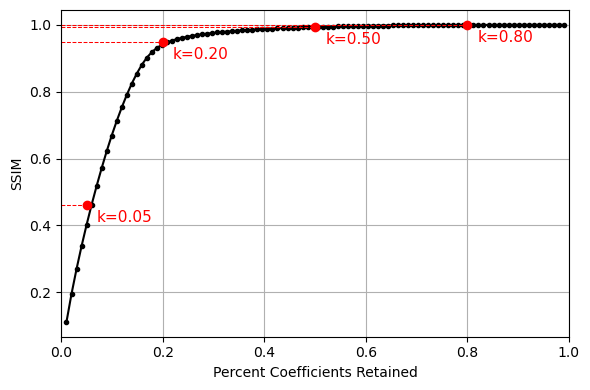

In [58]:
cutoffs = [0.05, 0.20, 0.50, 0.80]
sk = [reconstructions['ssim'][np.argwhere(keep_percs >= k)[0][0]] for k in cutoffs]

plt.figure(figsize=(6,4))
plt.plot(keep_percs, reconstructions['ssim'], 'k.-')

plt.plot(cutoffs, sk, 'ro')
[plt.text(z+0.02, sk[i]-0.05, 'k={:.2f}'.format(z), fontdict={'fontsize':11, 'color':'r'}) for i, z in enumerate(cutoffs)]
[plt.hlines(y=sk[i], xmin=0, xmax=cutoffs[i], color='r', linestyle='--', lw=0.75) for i in range(len(cutoffs))]

plt.grid(True, which='both')
plt.xlabel('Percent Coefficients Retained')
plt.ylabel('SSIM')
plt.xlim([0, 1])

plt.tight_layout()
plt.show()

In [ ]:
recs = [reconstructions['xhat'][np.argwhere(keep_percs >= k)[0][0]] for k in cutoffs]

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(10, 7), sharex=True, sharey=True)

for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))

    for i in range(4):
        axs[i,j].imshow(recs[i][j], cmap='jet')

    axs[4,j].imshow(df_perm[j], cmap='jet')
    [spine.set_edgecolor('r') for spine in axs[4, j].spines.values()]
    [spine.set_linewidth(2) for spine in axs[4, j].spines.values()]

for i in range(4):
    axs[i,0].set(ylabel='k={:.2f}'.format(cutoffs[i]))
axs[-1,0].set_ylabel('Original', color='r')

plt.tight_layout()
plt.show()

In [ ]:
wavelet = 'haar'
level = 1
axes_wt = (-2, -1)

coeffs = wavedec2(df_perm, wavelet=wavelet, level=level, axes=axes_wt)

coeff_arr, coeff_slices = coeffs_to_array(coeffs, axes=axes_wt)  #array of coeffs
coeff_sort = np.sort(np.abs(coeff_arr.reshape(-1)))              #flatten & sort

#reconstruct with only k% coefficient
keep_perc = 0.99

threshold = coeff_sort[int(np.floor((1-keep_perc)*len(coeff_sort)))]
coeff_arr_t = coeff_arr * (np.abs(coeff_arr) > threshold)
coeffs_t = array_to_coeffs(coeff_arr_t, coeff_slices, output_format='wavedec2')
reconstructions = waverec2(coeffs_t, wavelet=wavelet)

print(coeff_arr.min(), coeff_arr.max())
print(reconstructions.shape)

r2 = r2_score(df_perm_f, reconstructions.reshape(500, -1))
ssim = structural_similarity(df_perm, reconstructions, data_range=1)
psnr = peak_signal_noise_ratio(df_perm, reconstructions, data_range=1)
print('R2: {:.4f} | SSIM: {:.4f} | PSNR: {:.4f}'.format(r2, ssim, psnr))

fig, axs = plt.subplots(3, 10, figsize=(12,5), sharex=True, sharey=True)
vrange = 0.33
k = 0
for i in range(3):
    for j in range(10):
        ax = axs[i,j]
        ax.imshow(coeff_arr[k], cmap='coolwarm', vmin=-vrange, vmax=vrange)
        ax.set(xticks=[], yticks=[], title='wc$_{%d}$'%(k+1))
        k += 1
plt.tight_layout()
plt.show()

In [ ]:
wavelet = 'haar'
level = 1
axes_wt = (-2, -1)

coeffs = wavedec2(df_perm, wavelet=wavelet, level=level, axes=axes_wt)

coeff_arr, coeff_slices = coeffs_to_array(coeffs, axes=axes_wt)  #array of coeffs
coeff_sort = np.sort(np.abs(coeff_arr.reshape(-1)))              #flatten & sort

#reconstruct with only k% coefficient
keep_perc = 0.50

threshold = coeff_sort[int(np.floor((1-keep_perc)*len(coeff_sort)))]
coeff_arr_t = coeff_arr * (np.abs(coeff_arr) > threshold)
coeffs_t = array_to_coeffs(coeff_arr_t, coeff_slices, output_format='wavedec2')
reconstructions = waverec2(coeffs_t, wavelet=wavelet)
xdiff = np.abs( (df_perm - reconstructions) )

print(coeff_arr.min(), coeff_arr.max())
print(reconstructions.shape, xdiff.shape)

r2 = r2_score(df_perm_f, reconstructions.reshape(500, -1))
ssim = structural_similarity(df_perm, reconstructions, data_range=1)
psnr = peak_signal_noise_ratio(df_perm, reconstructions, data_range=1)
print('R2: {:.4f} | SSIM: {:.4f} | PSNR: {:.4f}'.format(r2, ssim, psnr))


fig, axs = plt.subplots(3, 5, figsize=(12,5), sharex=True, sharey=True)
for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))
    im1 = axs[0,j].imshow(df_perm[j], cmap='jet')
    im2 = axs[1,j].imshow(reconstructions[j], cmap='jet')
    im3 = axs[2,j].imshow(xdiff[j], cmap='binary', vmin=0, vmax=0.2)

    [spine.set_edgecolor('r') for spine in axs[0, j].spines.values()]
    [spine.set_edgecolor('b') for spine in axs[1, j].spines.values()]

    axs[2,j].set_xlabel('$R^2$={:.2f}\nSSIM={:.2f}'.format(100*r2_score(df_perm[j].flatten(), reconstructions[j].flatten()), structural_similarity(df_perm[j], reconstructions[j], data_range=1)))

    [plt.colorbar(im, ax=ax) for im, ax in zip([im1, im2, im3], axs[:,j])]
    
    for i in range(3):
        axs[i,j].set(xticks=[], yticks=[])

axs[0,0].set_ylabel('Original', color='r')
axs[1,0].set_ylabel('Reconstructed', color='b')
axs[2,0].set_ylabel('Absolute Difference', color='k')
plt.tight_layout()
plt.show()

***
# Dictionary Learning

In [14]:
import matplotlib.pyplot as plt
import pickle
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from sklearn.metrics import r2_score, mean_squared_error

import numpy as np
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import SparseCoder

df_perm = np.load('data/data_500_128x128.npy')
df_perm_f = np.reshape(df_perm, (df_perm.shape[0], -1))

In [60]:
# n_atoms = 500
# dl = MiniBatchDictionaryLearning(n_components=n_atoms, batch_size=10, n_jobs=8)
# dictionary = dl.fit(df_perm_f)
# atoms = dictionary.components_
# print('Dictionary shape: {} | Iterations: {}'.format(atoms.shape, dictionary.n_iter_))

with open('dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)
atoms = dictionary.components_

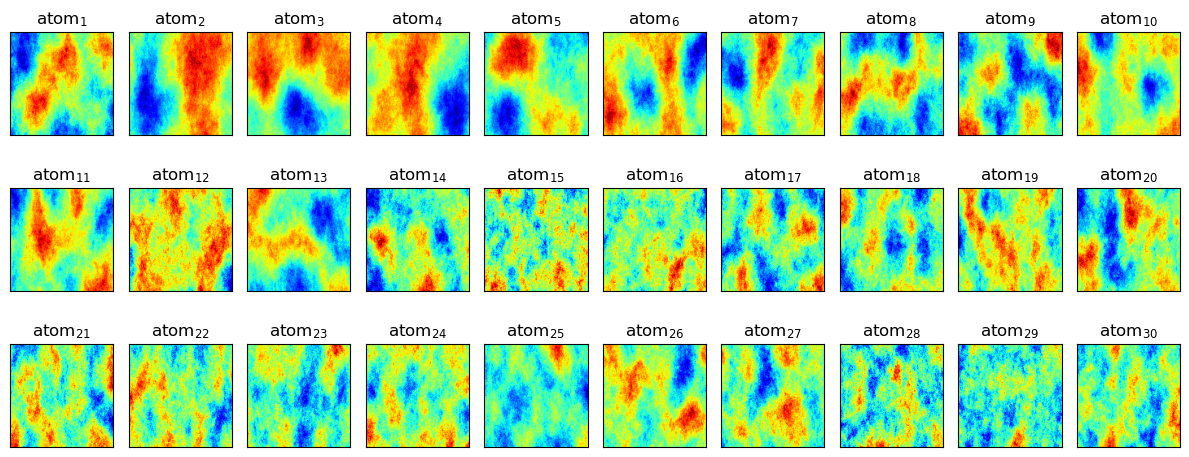

In [61]:
fig, axs = plt.subplots(3, 10, figsize=(12,5), sharex=True, sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        ax = axs[i,j]
        ax.imshow(atoms[k].reshape(128, 128), cmap='jet')
        ax.set(xticks=[], yticks=[], title='atom$_{%d}$'%(k+1))
        k += 1
plt.tight_layout()
plt.show()

In [62]:
sparse_code = SparseCoder(atoms).fit_transform(df_perm_f)
sparse_recs = np.reshape(sparse_code @ atoms, df_perm_f.shape)

print('Atoms: {}'.format(atoms.shape))
print('Sparse code shape: {}'.format(sparse_code.shape))
print('Reconstructions: {}'.format(sparse_recs.shape))

Atoms: (500, 16384)
Sparse code shape: (500, 500)
Reconstructions: (500, 16384)


In [63]:
kk = np.arange(1, 500, step=5)

recs = [sparse_code[:, :k] @ atoms[:k] for k in kk]

r2 = [r2_score(df_perm_f, r) for r in recs]
mse = [mean_squared_error(df_perm_f, r) for r in recs]
ssim = [structural_similarity(df_perm, np.reshape(r, df_perm.shape), data_range=1) for r in recs]
psnr = [peak_signal_noise_ratio(df_perm, np.reshape(r, df_perm.shape), data_range=1) for r in recs]

In [70]:
cutoffs = [0.2, 0.5, 0.8, 0.95]
sk = [np.argwhere(np.array(ssim) > k)[0] for k in cutoffs]

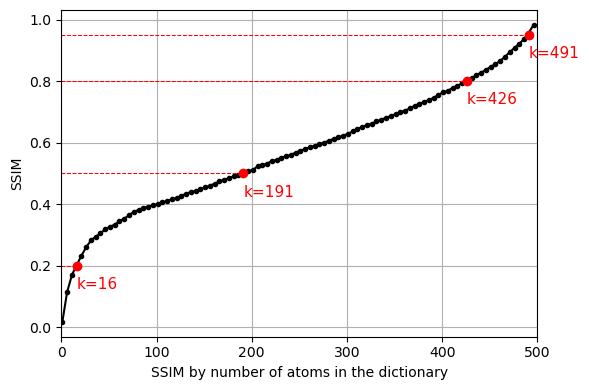

In [102]:
plt.figure(figsize=(6,4))

plt.plot(kk, ssim, 'k.-')
plt.plot(kk[sk], cutoffs, 'ro')
plt.hlines(y=cutoffs, xmin=0, xmax=kk[sk], color='r', linestyle='--', lw=0.75)
[plt.text(z, cutoffs[i]-0.075, 'k={}'.format(z[0]), fontdict={'fontsize':11, 'color':'r'}) for i, z in enumerate(kk[sk])]

plt.xlabel('SSIM by number of atoms in the dictionary')
plt.ylabel('SSIM')
plt.xlim(0,500)
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

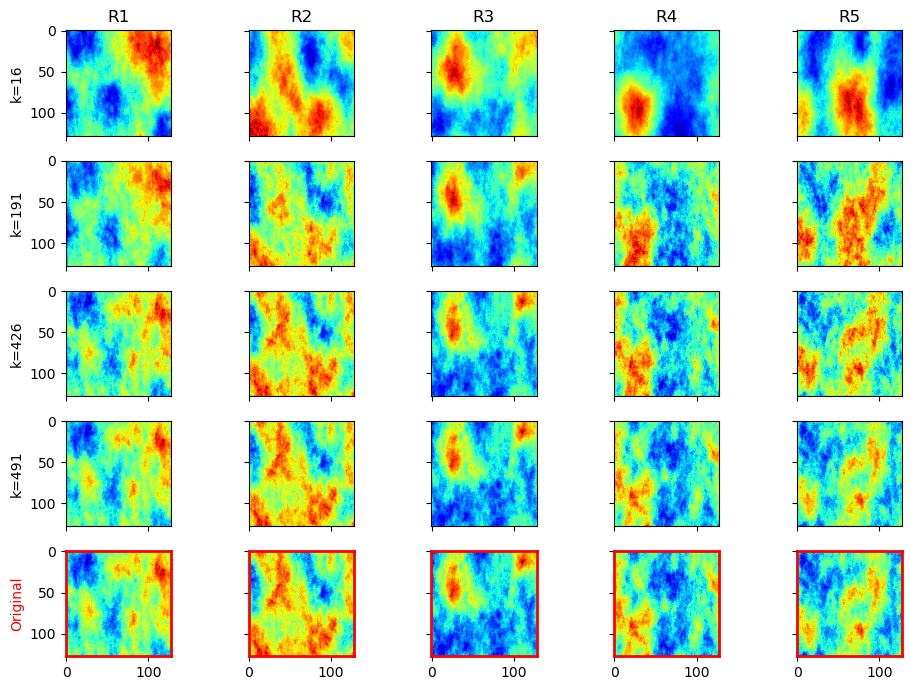

In [118]:
fig, axs = plt.subplots(5, 5, figsize=(10, 7), sharex=True, sharey=True)

for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))

    for i in range(4):
        axs[i,j].imshow(recs[sk[i][0]].reshape(df_perm.shape)[j], cmap='jet')

    axs[4,j].imshow(df_perm[j], cmap='jet')
    [spine.set_edgecolor('r') for spine in axs[4, j].spines.values()]
    [spine.set_linewidth(2) for spine in axs[4, j].spines.values()]


for i in range(4):
    axs[i,0].set(ylabel='k={}'.format(kk[sk][i][0]))
axs[-1,0].set_ylabel('Original', color='r')

plt.tight_layout()
plt.show()

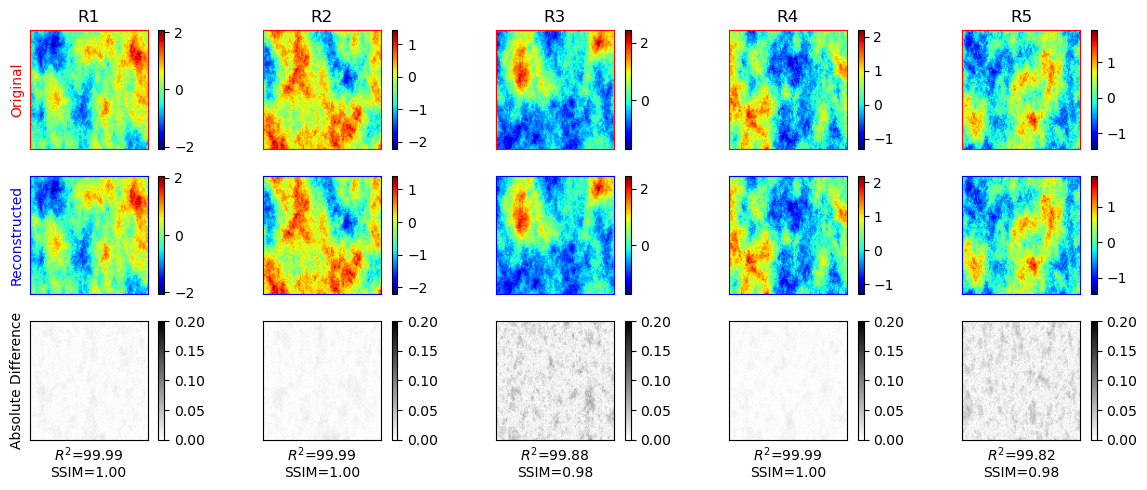

In [142]:
xhat = recs[sk[-1][0]].reshape(df_perm.shape)
xdiff = np.abs( (df_perm - xhat) )

fig, axs = plt.subplots(3, 5, figsize=(12,5), sharex=True, sharey=True)
for j in range(5):
    axs[0,j].set(title='R{}'.format(j+1))
    im1 = axs[0,j].imshow(df_perm[j], cmap='jet')
    im2 = axs[1,j].imshow(xhat[j], cmap='jet')
    im3 = axs[2,j].imshow(xdiff[j], cmap='binary', vmin=0, vmax=0.2)

    [spine.set_edgecolor('r') for spine in axs[0, j].spines.values()]
    [spine.set_edgecolor('b') for spine in axs[1, j].spines.values()]

    axs[2,j].set_xlabel('$R^2$={:.2f}\nSSIM={:.2f}'.format(100*r2_score(df_perm[j].flatten(), xhat[j].flatten()), structural_similarity(df_perm[j], xhat[j], data_range=1)))

    [plt.colorbar(im, ax=ax) for im, ax in zip([im1, im2, im3], axs[:,j])]
    
    for i in range(3):
        axs[i,j].set(xticks=[], yticks=[])

axs[0,0].set_ylabel('Original', color='r')
axs[1,0].set_ylabel('Reconstructed', color='b')
axs[2,0].set_ylabel('Absolute Difference', color='k')

plt.tight_layout()
plt.show()

***
# AutoEncoder

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

def check_torch(verbose:bool=True):
    if torch.cuda.is_available():
        torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
        count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
        if verbose:
            print('-'*60)
            print('----------------------- VERSION INFO -----------------------')
            print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
            print('# Device(s) available: {}, Name(s): {}'.format(count, name))
            print('-'*60)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return device
    else:
        torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
        if verbose:
            print('-'*60)
            print('----------------------- VERSION INFO -----------------------')
            print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
            print('-'*60)
        device = torch.device('cpu')
        return device
device = check_torch(verbose=True)

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.5.1.post303 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------


In [189]:
X_dataset = torch.tensor(np.expand_dims(df_perm,1), dtype=torch.float32)
X_train, X_valid = random_split(X_dataset, [400, 100])

trainloader = DataLoader(X_train, batch_size=16, shuffle=True)
validloader = DataLoader(X_valid, batch_size=16, shuffle=False)

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2)
        
    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        bn = nn.BatchNorm2d(out_channels)
        relu = nn.ReLU()
        return nn.Sequential(conv, bn, relu)
    
    def deconv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        deconv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        bn = nn.BatchNorm2d(out_channels)
        relu = nn.ReLU()
        return nn.Sequential(deconv, bn, relu)
    
    def forward(self, x):
        x = self.pool(self.conv_block(1, 16)(x))
        x = self.pool(self.conv_block(16, 32)(x))
        x = self.pool(self.conv_block(32, 64)(x))

        x = self.upsample(self.conv_block(64, 32)(x))
        x = self.upsample(self.conv_block(32, 16)(x))
        x = self.upsample(self.conv_block(16, 1)(x))

        return x

In [190]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss().to(device)

epochs, monitor = 100, 10
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    for i, x in enumerate(trainloader):
        x = x.to(device)
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, x)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for i, x in enumerate(validloader):
            x = x.to(device)
            y = model(x)
            loss = criterion(y, x)
            epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    if epoch % monitor == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(epoch+1, epochs, train_loss[-1], valid_loss[-1]))

ValueError: optimizer got an empty parameter list